In [1]:
# !pip install ../pyldpc
# !pip install pyeer

In [2]:
import numpy as np
import pandas as pd
import hashlib
import random
import sys
sys.path.append("../")
# from python_fuzzy_extractor.fuzzy_extractor import FuzzyExtractor
from python_fuzzy_extractor.fuzzy_extractor_LDPC import FuzzyExtractorLDPC as FuzzyExtractor
from entropy import Entropy
import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle
import itertools
from verification import computeAccuracyROC
from multiprocessing import Pool
import time
# from fuzzy_extractor import FuzzyExtractor

from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats
import matplotlib.pyplot as pyplot


In [3]:
# paramters
# enroll
total_length = 16 # length of input of fuzzy extractor
#The number of bits that can be flipped in the source value and 
# still produce the same key with probability (1 - rep_err).
error_precision = 8
top_score = 128# factor of 16
blocks = int(top_score / total_length)
using_max_entropy_or_random_perm = True
perm_feat = False# use perm for each user?

# Define IoM hashing

In [4]:
def genW(n,q,m):# m, hashcode length, q sub-dimentsion n data dimension
    return np.random.rand(m,n,q)

def IoMhashing(x,ws):
    para = np.shape(ws)
    hashcode = np.zeros(para[0])
    for i in range(para[0]):
        hashcode[i] = np.argmax(np.matmul(x,ws[i]))
    return hashcode
def IoM(embeddings,ws):
    emb_size = np.shape(embeddings)
    hashcodes = np.zeros((emb_size[0],np.shape(ws)[0]))
    for i in range(emb_size[0]):
        hashcodes[i][:] = IoMhashing(embeddings[i],ws).astype(int)
    return hashcodes.astype(int)
def euclidean_distance(hashcode,hashcode2):
    return np.linalg.norm(hashcode - hashcode2, axis=-1)/(np.linalg.norm(hashcode)+np.linalg.norm(hashcode2))
#  n how many numbers to choose
def nchoosek(startnum, endnum, step=1, n=1):
    c = []
    for i in itertools.combinations(range(startnum,endnum+1,step),n):
        c.append(list(i))
    return c



In [5]:
# embeddings = np.loadtxt('integerhashingcodes_embeddings_FVC2002_DB1_A_8x512.csv', dtype='int', delimiter=',')#512, binary
embeddings_kpca = np.loadtxt('data/kpca_embeddings_FVC2002_DB1.csv', dtype='float', delimiter=',')#512, binary

In [6]:
# test EER
def generateMatchingScores(embeddings):
    gen = [];
    combination = nchoosek(0,4, n=2)
    for i in range(100):
        for j in range(len(combination)):
            template1 = embeddings[(5*(i-1)+combination[j][0]),:]
            template2 = embeddings[(5*(i-1)+combination[j][1]),:]
            D=1- euclidean_distance(template1,template2)
            gen.append(D)
    imp = [];
    combination = nchoosek(0,99, n=2)
    for i in range(len(combination)):
        template1 = embeddings[(5*(combination[i][0]-1)+1),:]
        template2 = embeddings[(5*(combination[i][1]-1)+1),:]
        D=1 - euclidean_distance(template1,template2)
        imp.append(D)
    return (gen,imp)

# Perforamnce of KPCA

0.13080808080808082 %


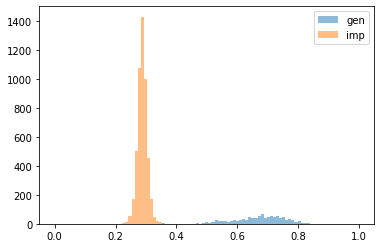

In [7]:
gen,imp = generateMatchingScores(embeddings_kpca)
stats_a = get_eer_stats(gen,imp)
print(stats_a.eer*100,'%')
# generate_eer_report([stats_a], ['A'], 'pyeer_report.csv')
plot_eer_stats([stats_a], ['A'])

bins = np.linspace(0, 1, 100)
pyplot.hist(gen, bins, alpha=0.5, label='gen')
pyplot.hist(imp, bins, alpha=0.5, label='imp')
pyplot.legend(loc='upper right')


# Performance of IoM

0.592929292929293 %


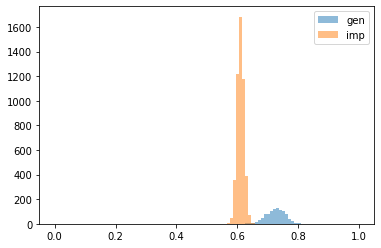

In [8]:
num_user, dx = np.shape(embeddings_kpca)
W = genW(dx,8,512)
embeddings_iom = IoM(embeddings_kpca,W)

gen,imp = generateMatchingScores(embeddings_iom)
stats_a = get_eer_stats(gen,imp)
print(stats_a.eer*100,'%')
# generate_eer_report([stats_a], ['A'], 'pyeer_report.csv')
plot_eer_stats([stats_a], ['A'])

bins = np.linspace(0, 1, 100)
pyplot.hist(gen, bins, alpha=0.5, label='gen')
pyplot.hist(imp, bins, alpha=0.5, label='imp')
pyplot.legend(loc='upper right')


In [9]:
# # convert into binary array
# def bin_array(num, m):
#     """Convert a positive integer num into an m-bit bit vector"""
#     return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)
# def binary_to_decimal(binary):
#     i,integer = 0,0
#     size = len(binary)
#     while i < len(binary):
#         integer += int(binary[size - 1 - i])*pow(2,i)
#         i+=1
#     return integer

# size = np.shape(embeddings)
# embeddings_bin =  np.zeros((size[0],size[1]*8))
# for i in range(500):
#     embeddings_bin[i][:] = np.array([bin_array(m,8) for m in embeddings[i]]).reshape(-1)

# embeddings = embeddings_bin.astype(np.int8)
# # size = np.shape(embeddings)
# # embeddings_16x64 =  np.zeros((size[0],size[1]*8))
# # for i in range(500):
# #     this_bin = np.array([bin_array(m,8) for m in embeddings[i]]).reshape(-1)
# #     embeddings_bin[i][:] = this_bin
# # # embeddings_bin = [bin_array(m,8) for m in embeddings]


In [10]:
extractor = FuzzyExtractor(total_length, error_precision)

# For each user, generate mask from first 3 samples

In [11]:
mess_len = embeddings_iom.shape[1]
masks=[]
for i in tqdm.tqdm(range(100)):
    samples = embeddings_iom[i*5:i*5+3,:]
    entropy_scores = []
    for i in range(mess_len):
        entropy_scores.append(Entropy(samples[:,i]))
    entropy_scores_sort_idx = np.argsort(entropy_scores)
    if using_max_entropy_or_random_perm:
        remain_idx =np.array(entropy_scores_sort_idx, dtype=np.uint8)
    else:
        remain_idx =np.random.permutation(range(512))# if randomly generate index?
    masks.append(remain_idx)

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


# what if we add some permutation? User-specific?

In [12]:
perms=[]
for i in tqdm.tqdm(range(100)):
    perms.append(np.random.permutation(range(top_score)))


100%|██████████| 100/100 [00:00<00:00, 24170.48it/s]


# 4th samples as enrollment template, 5 as testing

In [13]:
def randomExclude(n):
    while True:
        tmp = np.random.randint(0, 100, size=1)[0]
        if tmp!=n:
            break
    return tmp

flg=1# debug,one element 


def sub_enroll(i):
    keys= []
    helpers = []
    samples = embeddings_iom[i*5+3,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
#     print(samples_masked)
#     samples_masked = np.array([binary_to_decimal(samples_masked[idx*8:(idx+1)*8]) for idx in range(16)])
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    for starti in range(blocks):
        s = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor
        key, helper = extractor.generate(s)
        keys.append(key)
        helpers.append(helper)
    return keys,helpers



In [ ]:
# enroll
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_enroll, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


keys= []
helpers = []
    
for i in range(100):
    ikeys,ihelpers = results[i].get(timeout=100)
    keys.append(ikeys)
    helpers.append(ihelpers)

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======


# Query and test

In [ ]:
# np.savez('masks.npy',masks)
# np.savez('keys.npy',keys)
# np.savez('embeddings.npy',embeddings)

In [ ]:
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r

# filename = save_variable(helpers,'helpers.txt')
# results = load_variavle('helpers.txt')
#################################
def sub_repro_imposter(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings_iom[j*5+4,:]## using imposter biometric data
    mask = masks[j][:top_score]
    samples_masked = samples[mask]
#     samples_masked = np.array([binary_to_decimal(samples_masked[idx*8:(idx+1)*8]) for idx in range(16)])
    key = keys[i]
    helper = helpers[i]
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
    return positive_num

def sub_repro_imposter_disclosure_mask(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings_iom[j*5+4,:]## using imposter biometric data
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
#     samples_masked = np.array([binary_to_decimal(samples_masked[idx*8:(idx+1)*8]) for idx in range(16)])
    key = keys[i]
    helper = helpers[i]
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[j]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
    return positive_num


def sub_repro_genuine(i):
    samples = embeddings_iom[i*5+4,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
#     samples_masked = np.array([binary_to_decimal(samples_masked[idx*8:(idx+1)*8]) for idx in range(16)])

    key = keys[i]
    helper = helpers[i]

    # perm the hash codes
#     samples_masked = samples_masked[perms[i]]
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):        
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
#         print('***********************************************')
#         print('++++',r_key,key[starti],'******',starti)
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
#         if r_key == None:
#             continue
#         elif abs(np.subtract(r_key, key[starti])).sum() == 0:#r_key==key[starti]
#             positive_num = positive_num+1
# #     print('process',i,positive_num)
    return positive_num

In [ ]:
# query
#lets try 7th with mated
positive_nums=[]

pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_genuine, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")
# print(positive_nums)


In [ ]:
print(sum(np.array(positive_nums)>0)/len(positive_nums))
# positive_nums 76% wo ldpc  78 wLDPC

# imposter

## imposter knows 

In [ ]:
false_positive_nums = []
pool = Pool(processes = 10)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


In [ ]:
false_positive_nums_same_mask = []
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter_disclosure_mask, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums_same_mask.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


In [ ]:
print(positive_nums)
# print(false_positive_nums)
print(false_positive_nums_same_mask)
print(false_positive_nums)
print('blocks',blocks)
# print(false_positive_nums2)
threshold1 = max(false_positive_nums)+1
threshold2 = max(false_positive_nums_same_mask)+1
# threshold = 1
print('threshold1:',threshold1)
print('threshold2:',threshold2)
positive_nums = np.array(positive_nums)
# false_positive_nums = np.array(false_positive_nums)
false_positive_nums = np.array(false_positive_nums)
false_positive_nums_same_mask = np.array(false_positive_nums_same_mask)

## 
tpr = sum(positive_nums>=threshold1)/len(positive_nums)
fpr = sum(false_positive_nums>=threshold1)/len(false_positive_nums)

print('tpr,fpr',tpr,fpr)

## 
tpr = sum(positive_nums>=threshold2)/len(positive_nums)
fpr_same_mask = sum(false_positive_nums_same_mask>=threshold2)/len(false_positive_nums_same_mask)

print('tpr,fpr_samemask',tpr,fpr_same_mask)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patches = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums,bins=30,rwidth=1)


In [ ]:
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patchesshape = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums_same_mask,bins=30,rwidth=1)


# result 0FAR
